In [67]:
import pandas as pd
import numpy as np
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
%matplotlib inline  

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import nltk
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.corpus import stopwords, words
    from nltk import FreqDist

    import gensim
    from gensim import corpora, models, similarities
    import pyLDAvis
    import pyLDAvis.gensim

In [2]:
cities = pd.read_csv('cities_geo2_df.csv', index_col=0)

# Reset index
cities = cities.reset_index()
cities.drop(['index'], axis=1, inplace=True)

In [3]:
#cities.head()

In [4]:
# # Run once
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('words')

In [5]:
tokenizer = RegexpTokenizer(r'\w+') # retains alphanumeric character
lmtzr = WordNetLemmatizer()
cached_stop_words = stopwords.words("english")

In [6]:
def lemmatize_dropstop_words(text): 
    print(text)
    clear_output(wait=True)
    return [lmtzr.lemmatize(word) for word in text if 
            (len(word)>2) and 
            (lmtzr.lemmatize(word) not in cached_stop_words) and 
            (word in words.words())
            ]

def remove_num(text): 
    return re.sub("\d+", " ", text)

In [7]:
cities = cities.replace(np.nan, '', regex=True)

In [8]:
# Add my stop words from txt file
my_stop_words = np.genfromtxt('my_stop_words.txt',dtype='str', delimiter=', ').tolist()
cached_stop_words.extend(my_stop_words)

In [9]:
# Read
REFILTER_WORDS = False

In [10]:
if REFILTER_WORDS == True:
    cities['See_tokens'] = cities['See'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)

In [11]:
if REFILTER_WORDS == True:
    cities['Do_tokens'] = cities['Do'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)
        
    # Pool tokens
    def pool_tokens(row):
        return row['See_tokens']+row['Do_tokens']

    cities['Pooled_tokens'] = cities.apply(pool_tokens, axis=1)

In [12]:
if REFILTER_WORDS == True:
    cities['Understand_tokens'] = cities['Understand'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)

In [13]:
if REFILTER_WORDS == True:
    cities['Stay safe_tokens'] = cities['Stay safe'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)

In [14]:
if REFILTER_WORDS == False:
    cities = pd.read_csv('cities_text_processed_df.csv', index_col = 0)

In [15]:
# If reloaded from .csv file, convert string to list
if type(cities['Pooled_tokens'][0])==str:
    cities['Pooled_tokens'] = cities['Pooled_tokens'].apply(ast.literal_eval)

In [16]:
# Most common words
words = []
for sublist in cities['Pooled_tokens']:
    for item in sublist:
        words.append(item)
        
fdist = FreqDist(words)
fdist.most_common(20)

[('museum', 9558),
 ('park', 7930),
 ('art', 3857),
 ('free', 3827),
 ('old', 3576),
 ('temple', 3433),
 ('well', 3299),
 ('center', 3062),
 ('world', 2996),
 ('town', 2972),
 ('festival', 2790),
 ('road', 2779),
 ('bus', 2682),
 ('river', 2681),
 ('small', 2613),
 ('church', 2584),
 ('walk', 2574),
 ('station', 2569),
 ('local', 2454),
 ('great', 2406)]

In [17]:
# Manual clean up some city names (European cities with alternate spelling) or duplicate city names
replacements = [
    ['Germany', 'München', 'Munich'],
    ['Czech Republic', 'Praha', 'Prague'],
    ['Italy', 'Florencia', 'Florence'],
    ['Italy', 'Roma', 'Rome'],
    ['Portugal', 'Lisboa', 'Lisbon'],
    ['Spain', 'Sevilla', 'Seville'],
    ['Greece', 'Athinai', 'Athens'],
    ['Poland', 'Wroclaw', 'Warsaw'],
    ['Italy', 'Milano', 'Milan'],
    ['Austria', 'Wien', 'Vienna'],
    
    ['Canada', 'London', 'London (C)'],
    ['Canada', 'Cambridge', 'Cambrdige (C)'],
    ['Argentina', 'Cordoba', 'Cordoba (A)'],
    ['United States', 'Cambridge', 'Cambrdige (US)'],
    ['United States', 'Vancouver', 'Vancouver (US)'],
    ['United States', 'Saint Petersburg', 'Saint Petersburg (US)'],
    ['United Kingdom', 'Newark', 'Newark (UK)'],
    ['United Kingdom', 'Rochester', 'Rochester (UK)']
]

for row in replacements:
    cities.loc[(cities.Country==row[0]) & (cities.City==row[1]), 'City']=row[2]

In [18]:
#cities[cities.duplicated(subset='City', keep=False)==True]

In [19]:
# Save cities with final index
cities.to_csv('cities_text_processed_df.csv')

In [20]:
# Join tokens to one string to be compatible w/ sklearn models
def tokens_to_str(tokens):
    return ' '.join(tokens)

cities['Pooled_string'] = cities['Pooled_tokens'].apply(tokens_to_str)

# Vectorize text

In [21]:
# Add some more geography-referencing words that escaped the english stopwords dict
stoplist2 = ['new','york']

def stop_words2(tokens):
    newlist = []
    for word in tokens:
        if word not in stoplist2:
            newlist.append(word)
    return newlist

In [22]:
# Final level of stop words
cities['Pooled_tokens2'] = cities['Pooled_tokens'].apply(stop_words2)
cities['Pooled_string2'] = cities['Pooled_tokens2'].apply(tokens_to_str)

In [23]:
# Initialize Model
vec=TfidfVectorizer(min_df=3)

In [24]:
# CountVec fit to Bag of Words
vec1 = vec.fit_transform(cities['Pooled_string2'])

In [25]:
# Cosine similarity matrix
cosims_mat = 1-pairwise_distances(vec1.A, metric="cosine")
cosims_mat

cosims_df = pd.DataFrame(cosims_mat)
cosims_df.head()

# Save
cosims_df.to_csv('data/cos_sims.csv')

# Save stacked version
cosims_stacked = cosims_df.stack()
cosims_stacked.to_csv('data/cos_sims_stacked.csv')

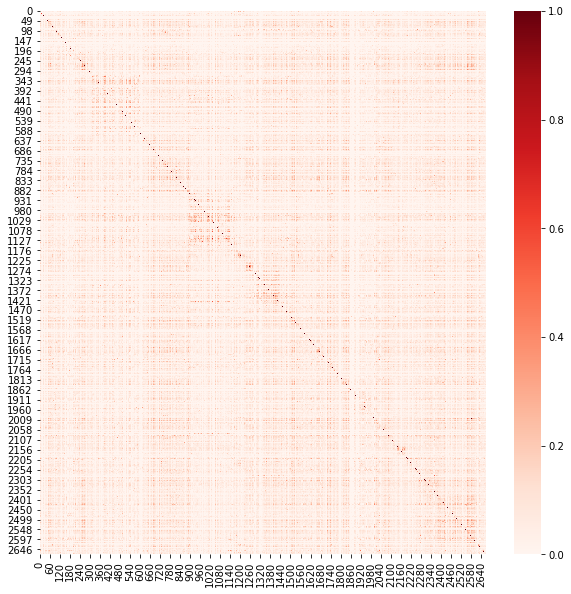

In [26]:
# Visualize cosims matrix

plt.figure(figsize=(10,10))
sns.heatmap(cosims_df.values,cmap='Reds')

In [27]:
# Test output cities given user input

input_city = 'London'
input_index = [cities[cities['City']==input_city].index]
output_index = cosims_df.iloc[input_index[0][0]].sort_values(ascending = False).head(10)
cities.iloc[output_index.index]

,Country,City,Understand,Get in,Get around,See,Do,Buy,Eat,Sleep,...,Longitude,AccentCity,See_tokens,Do_tokens,Pooled_tokens,Understand_tokens,Stay safe_tokens,Pooled_string,Pooled_tokens2,Pooled_string2
2318,United Kingdom,London,"""When a man is tired of London, he is tired of...",By plane[edit] Due to London's huge global cit...,London has one of the most comprehensive publi...,London with children London can be stressf...,"London is a huge city, so all individual listi...",Almost anything you could possibly want to buy...,This guide uses the following price ranges ...,This guide uses the following price ranges ...,...,NaN,NaN,"['stressful', 'check', 'slightly', 'stressful'...","['huge', 'individual', 'appropriate', 'distric...","[stressful, check, slightly, stressful, huge, ...","['man', 'tired', 'tired', 'life', 'life', 'aff...","['emergency', 'telephone', 'number', 'police',...",stressful check slightly stressful huge indivi...,"[stressful, check, slightly, stressful, huge, ...",stressful check slightly stressful huge indivi...
2310,United Kingdom,Glasgow,Defining Glasgow[edit] The term “Glasgow” in i...,By plane[edit] Glasgow is served by two main a...,Strathclyde Partnership for Transport [81] (SP...,Architecture[edit] As befits a city that was a...,"There are many nightclubs, concerts and festiv...",Glasgow has positioned itself as an upmarket r...,"The city has won the title ""Curry Capital of B...","Glasgow, like any other major British city has...",...,NaN,NaN,"['architecture', 'beginning', 'fine', 'legacy'...","['music', 'famous', 'music', 'scene', 'least',...","[architecture, beginning, fine, legacy, lavish...","['term', 'ambiguous', 'various', 'boundary', '...","['emergency', 'contact', 'number', 'rest', 'ne...",architecture beginning fine legacy lavish spec...,"[architecture, beginning, fine, legacy, lavish...",architecture beginning fine legacy lavish spec...
683,Denmark,Copenhagen,History[edit] If you had dropped by Copenhagen...,By plane[edit] Copenhagen's Kastrup Airport [6...,The two big hubs are Central Station (da: Hove...,Complete listings can be found in the appropri...,"Beach life[edit] In the inner harbour, water q...",Strøget is one of the largest pedestrian malls...,Please look for general restaurant listings in...,Hotel listings are available in the appropriat...,...,NaN,NaN,"['complete', 'appropriate', 'district', 'entra...","['beach', 'life', 'inner', 'harbour', 'water',...","[complete, appropriate, district, entrance, fr...","['history', 'eleventh', 'would', 'looking', 'q...",[],complete appropriate district entrance free we...,"[complete, appropriate, district, entrance, fr...",complete appropriate district entrance free we...
1918,Russia,Moscow,Moscow is the financial and political center o...,See Russia#Get in for visa requirements to Rus...,Walking[edit] Be wary of bicyclists on the sid...,Museums and religious buildings[edit] Red Squ...,"Moscow has many attractions, but many of them ...",Credit card acceptance is widespread. ATMs are...,Dining establishments in Moscow range from foo...,"With the exception of some high-end hotels, al...",...,NaN,NaN,"['religious', 'red', 'square', 'heart', 'desti...","['friendly', 'non', 'speaker', 'language', 'el...","[religious, red, square, heart, destination, s...","['financial', 'political', 'center', 'russia',...","['low', 'crime', 'rate', 'large', 'metropolis'...",religious red square heart destination surroun...,"[religious, red, square, heart, destination, s...",religious red square heart destination surroun...
2357,United Kingdom,Sheffield,Sheffield is built on and in-between seven hil...,"By plane[edit] Doncaster Sheffield Airport, on...",On foot in the City Centre[edit] Sheffield's c...,City Centre[edit] Sheffield city centre has un...,"Sheffield is a vibrant, cosmopolitan city and ...","Sheffield city centre is quite compact, so the...","There are many good, cheap places to eat in an...",City Centre[edit] City Crash Pad Serviced Apar...,...,NaN,

In [28]:
input_index = cities.index[cities['City']=='New York City'][0] # Get index of input
input_sims = pd.DataFrame(cosims_df.iloc[input_index]) # Get sims for input city
sims_sorted = input_sims.sort_values(by=input_index, ascending=False) # Sort sims
sims_top = sims_sorted.iloc[1:101]
top_index = sims_top.index
top_cities = cities.iloc[top_index][['City','Country','Lat','Lon','Pooled_tokens']]
top_cities

,City,Country,Lat,Lon,Pooled_tokens
2562,Rochester,United States,43.154784,-77.615555,"[popular, river, gorge, certainly, worth, trip..."
2506,Los Angeles,United States,34.052234,-118.243683,"[individual, district, lite, flight, lite, fli..."
2571,San Francisco,United States,37.774929,-122.419418,"[significant, detail, individual, district, li..."
2402,Austin,United States,30.267153,-97.743057,"[initially, drawn, hip, culture, live, music, ..."
2310,Glasgow,United Kingdom,55.833333,-4.250000,"[architecture, beginning, fine, legacy, lavish..."
1957,Saint Petersburg,Russia,59.894444,30.264166,"[historic, center, saint, related, world, heri..."
2428,Cincinnati,United States,39.162004,-84.456886,"[tower, observation, deck, vine, downtown, tow..."
2399,Atlanta,United States,33.748995,-84.387985,"[top, form, eclectic, mix, sure, something, ev..."
1724,Bergen,Norway,42.493889,-88.865278,"[number, surrounding, show, atmosphere, cultur..."
102,Brussels,Belgium,50.846598,4.352775,"[card, available, available, free, guidebook, ..."


In [29]:
cities.shape

(2671, 29)

# Creating narrow df for SQL server

In [30]:
# Keeo only necessary columns
cities_narrow = cities[['Country','City','Lat','Lon']]
cities_narrow.head()

,Country,City,Lat,Lon
0,Afghanistan,Herat,34.340000,62.189999
1,Afghanistan,Kabul,34.516667,69.183334
2,Afghanistan,Jalalabad,34.420000,70.449997
3,Afghanistan,Kandahar,31.610000,65.699997
4,Afghanistan,Kunduz,36.720000,68.860001


In [31]:
# Sorted index of top 10 similar cities
idx = np.argsort(-cosims_df, axis=1)
idx = idx.iloc[:,1:11]
idx.columns = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']
idx.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,1209,2624,1201,2210,599,1219,1055,962,1754,1232
1,233,1744,1742,1628,2607,2310,1746,885,2362,2015
2,1062,2637,995,1754,1,1193,1072,1099,991,1211
3,2000,1741,1220,1037,1980,929,2628,1133,1111,1002
4,0,1776,1777,1778,1779,1780,1781,1782,1783,1784


In [32]:
# Bottom 10
idx_bottom = np.argsort(cosims_df, axis=1)
idx_bottom = idx_bottom.iloc[:,:10]
idx_bottom.head()
idx_bottom.to_csv('cities_bottom10.csv')

In [33]:
cities_narrow_top10 = pd.concat([cities_narrow, idx],axis=1)

In [34]:
cities_narrow_top10.head()

,Country,City,Lat,Lon,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,Afghanistan,Herat,34.340000,62.189999,1209,2624,1201,2210,599,1219,1055,962,1754,1232
1,Afghanistan,Kabul,34.516667,69.183334,233,1744,1742,1628,2607,2310,1746,885,2362,2015
2,Afghanistan,Jalalabad,34.420000,70.449997,1062,2637,995,1754,1,1193,1072,1099,991,1211
3,Afghanistan,Kandahar,31.610000,65.699997,2000,1741,1220,1037,1980,929,2628,1133,1111,1002
4,Afghanistan,Kunduz,36.720000,68.860001,0,1776,1777,1778,1779,1780,1781,1782,1783,1784


In [35]:
# Save file to be used by server
cities_narrow_top10.to_csv('cities_narrow.csv')

In [36]:
# Code to be used from userver

In [37]:
input_index

2527

In [38]:
# Get index table
idx = cities_narrow_top10.loc[:,'s1':'s10']
idx.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,1209,2624,1201,2210,599,1219,1055,962,1754,1232
1,233,1744,1742,1628,2607,2310,1746,885,2362,2015
2,1062,2637,995,1754,1,1193,1072,1099,991,1211
3,2000,1741,1220,1037,1980,929,2628,1133,1111,1002
4,0,1776,1777,1778,1779,1780,1781,1782,1783,1784


In [39]:
cities_narrow_top10.iloc[idx.iloc[input_index]]

,Country,City,Lat,Lon,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
2562,United States,Rochester,43.154784,-77.615555,2506,2517,2428,2402,253,2444,275,2005,2586,290
2506,United States,Los Angeles,34.052234,-118.243683,2562,2428,2571,2536,2579,2586,2005,2402,2549,2517
2571,United States,San Francisco,37.774929,-122.419418,2506,2579,2562,2527,2372,2570,1724,2005,2586,2402
2402,United States,Austin,30.267153,-97.743057,2562,2506,2517,2443,2527,270,847,2428,2423,2579
2310,United Kingdom,Glasgow,55.833333,-4.250000,2274,2375,2327,2357,2318,2320,800,1225,2362,2334
1957,Russia,Saint Petersburg,59.894444,30.264166,1918,885,2008,1523,808,1724,2527,1979,1628,800
2428,United States,Cincinnati,39.162004,-84.456886,2562,2506,2547,2005,2586,2536,2517,2444,2424,2607
2399,United States,Atlanta,33.748995,-84.387985,2506,2549,2428,2005,2586,2562,2527,2536,2572,2579
1724,Norway,Bergen,42.493889,-88.865278,736,735,893,885,2089,102,808,800,1656,683
102,Belgium,Brussels,50.846598,4.352775,755,105,885,1656,800,1724,735,736,1675,2058


In [79]:
cities_narrow['Google_Term'] = cities_narrow["City"].map(str) + '+' + cities_narrow["Country"] + '+Wikitravel'
cities_narrow['Google_URL_Prefix'] = 'https://duckduckgo.com/?q=!ducky+'
cities_narrow['Google_URL'] = cities_narrow['Google_URL_Prefix'].map(str)+cities_narrow['Google_Term']

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [80]:
cities_narrow.head()

,Country,City,Lat,Lon,Google_Term,Google_URL_Prefix,Google_URL
0,Afghanistan,Herat,34.340000,62.189999,Herat+Afghanistan+Wikitravel,https://duckduckgo.com/?q=!ducky+,https://duckduckgo.com/?q=!ducky+Herat+Afghani...
1,Afghanistan,Kabul,34.516667,69.183334,Kabul+Afghanistan+Wikitravel,https://duckduckgo.com/?q=!ducky+,https://duckduckgo.com/?q=!ducky+Kabul+Afghani...
2,Afghanistan,Jalalabad,34.420000,70.449997,Jalalabad+Afghanistan+Wikitravel,https://duckduckgo.com/?q=!ducky+,https://duckduckgo.com/?q=!ducky+Jalalabad+Afg...
3,Afghanistan,Kandahar,31.610000,65.699997,Kandahar+Afghanistan+Wikitravel,https://duckduckgo.com/?q=!ducky+,https://duckduckgo.com/?q=!ducky+Kandahar+Afgh...
4,Afghanistan,Kunduz,36.720000,68.860001,Kunduz+Afghanistan+Wikitravel,https://duckduckgo.com/?q=!ducky+,https://duckduckgo.com/?q=!ducky+Kunduz+Afghan...


In [101]:
cities_narrow['Google_URL'][0]

'https://duckduckgo.com/?q=!ducky+Herat+Afghanistan+Wikitravel'

In [102]:
def get_redirected_URL(URL):
    r = requests.get(URL)
    print(r.url)
    clear_output(wait=True)
    return r.url
cities_narrow['Final_URL'] = cities_narrow['Google_URL'].apply(get_redirected_URL)

KeyboardInterrupt: 

In [100]:
r = requests.get('https://duckduckgo.com/?q=!ducky+Herat+Afghanistan+Wikitravel')


<Response [418]>